# Import packages

In [218]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import ot
import time
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

from utils import *

In [219]:
import sys
sys.path.append("../")

from lib.gromov import gromov_wasserstein, cost_matrix_d, tensor_dot_param, tensor_dot_func, gwgrad_partial1, partial_gromov_wasserstein, partial_gromov_ver1
from lib.gromov import GW_dist,MPGW_dist, PGW_dist_with_penalty

In [220]:
import torch
from lib.unbalanced_gromov_wasserstein.unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn
from lib.unbalanced_gromov_wasserstein.unbalancedgw._vanilla_utils import ugw_cost

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load Shapes

In [236]:
posns = np.load("bone_star_data.npz")
posns = list(posns.values())

alpha = 1/100
lengths = [x.shape[0] for x in posns] 
lengths=np.array(lengths)

heights = list()
for (id_x,x) in enumerate(posns):
    alpha=1/50 #np.max(lengths[0:140])
        #heights.append(alpha*np.ones(x.shape[0]))
    #else:
        #alpha=1/np.max(lengths[141:])
    heights.append(alpha*np.ones(x.shape[0]))




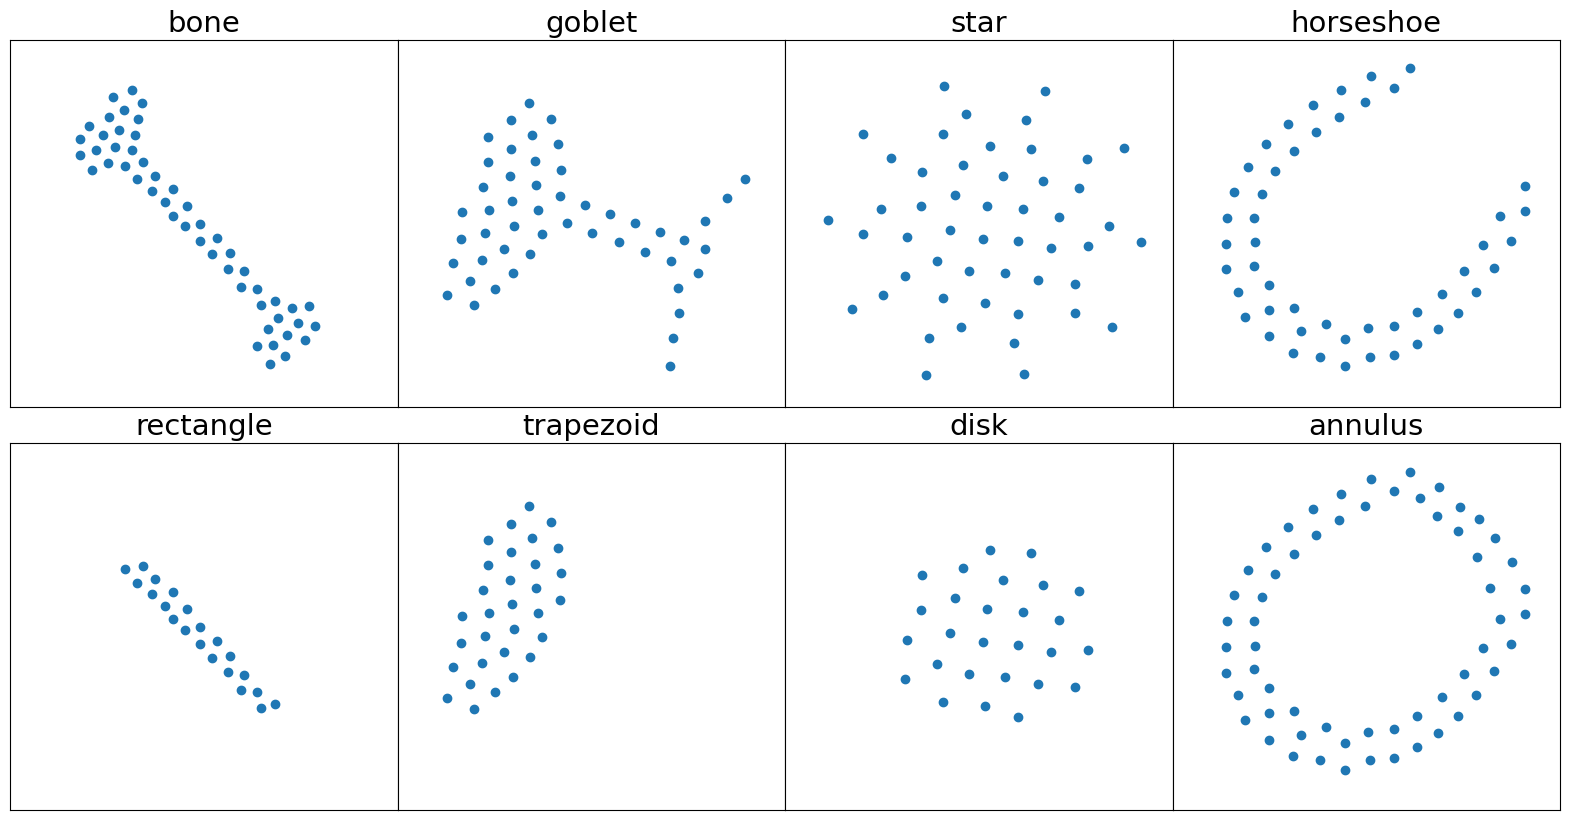

In [237]:
fig, ax = plt.subplots(2, 4, figsize=(20,10))

# Remove padding between subplots
plt.subplots_adjust(wspace=0, hspace=0.1)

indices = [0, 20, 41, 60]
titles = ["bone","goblet", "star", "horseshoe", "rectangle", "trapezoid", "disk", "annulus"]

for i in range(8):
    idx = indices[i % 4] + (80 if i >= 4 else 0)
    ax[i//4, i%4].scatter(posns[idx][:,0], posns[idx][:,1])
    ax[i//4, i%4].set_xlim(-.6, .6)
    ax[i//4, i%4].set_ylim(-.6, .6)
    ax[i//4, i%4].set_title(titles[i], fontsize=21)

    # Turn off x,y labels
    ax[i//4, i%4].set_xticks([])
    ax[i//4, i%4].set_yticks([])
    # ax[i//4, i%4].set_title(i * 20)

plt.savefig("bone_star_data.png", dpi=300, bbox_inches='tight')
plt.savefig("bone_star_data.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [238]:
posns = posns[:20] + posns[80:100] + posns[20:40] + posns[100:120] + posns[40:60] + posns[120:140] + posns[60:80] + posns[140:160]
heights = heights[:20] + heights[80:100] + heights[20:40] + heights[100:120] + heights[40:60] + heights[120:140] + heights[60:80] + heights[140:160]
len(posns)

160

In [239]:
numItem = 20
classes = np.arange(8)
N = len(classes)*20
N

160

In [240]:
Ms = []
LAMBDA_MAX = 0

for i in range(len(posns)):
    Ms.append(np.sqrt(cost_matrix_d(posns[i], posns[i])))
    LAMBDA_MAX = max(LAMBDA_MAX, Ms[i].max() ** 2)

# GW

In [241]:
st = time.time()        
gw = np.zeros((N,N))

for i in range(N):
    M1 = Ms[i]
    for j in range(i+1, N):
        M2 = Ms[j]

        height1 = np.ones(M1.shape[0]) / M1.shape[0]
        height2 = np.ones(M2.shape[0]) / M2.shape[0]

        gamma = gromov_wasserstein(M1, M2, height1, height2, G0=None,thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)
        gw[i, j] = GW_dist(M1, M2, gamma)
gw = np.sqrt(gw)
gw += gw.T
et = time.time()
print("GW computation: " + str(np.round(et-st,2)) + "s")

GW computation: 43.05s


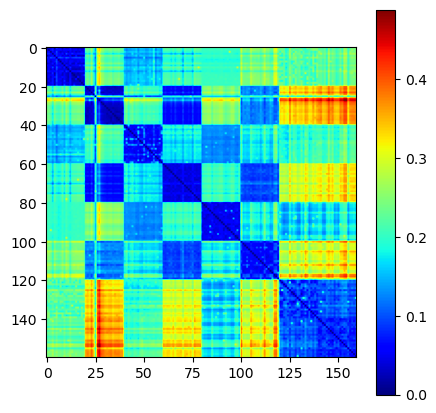

In [242]:
plt.figure(figsize=(5,5))
plt.imshow(gw, cmap='jet')
plt.colorbar()
plt.show()

# PGW

In [243]:
st = time.time()        
pgw = np.zeros((N,N))

for i in range(N):
    shape_i = posns[i]
    M1 = Ms[i]
    height1 = heights[i]

    for j in range(i+1, N):
        shape_j = posns[j]
        M2 = Ms[j]
        height2 = heights[j]

        Lambda = 1/5 * LAMBDA_MAX
        gamma = partial_gromov_ver1(M1, M2, height1, height2, G0=None, Lambda=Lambda, thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)

        pgw_trans,pgw_penalty=PGW_dist_with_penalty(M1,M2,gamma, height1, height2, Lambda)
        pgw[i, j]=pgw_trans+pgw_penalty 

pgw[pgw < 0] = 0
pgw += pgw.T
pgw = np.sqrt(pgw)

et = time.time()
print("PGW computation: " + str(np.round(et-st,2)) + "s")


accs_pgw, mean_acc_pgw = svm_cross_val(pgw)
print("Mean accuracy for PGW: ", mean_acc_pgw)




PGW computation: 29.58s
Mean accuracy for PGW:  0.9375


Mean accuracy for PGW:  0.9375


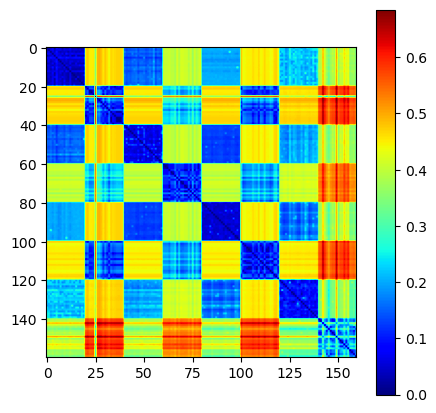

In [244]:

accs_pgw, mean_acc_pgw = svm_cross_val(pgw)
print("Mean accuracy for PGW: ", mean_acc_pgw)
plt.figure(figsize=(5,5))
plt.imshow(pgw, cmap='jet')
plt.colorbar()
plt.show()

# Mass Constrained PGW

In [51]:
st = time.time()        
mpgw = np.zeros((N,N))

for i in range(N):
    shape_i = posns[i]
    M1 = Ms[i]
    height1 = heights[i]

    for j in range(i+1, N):
        shape_j = posns[j]
        M2 = Ms[j]
        height2 = heights[j]

        mass = min(height1.sum(), height2.sum())
        gamma = partial_gromov_wasserstein(M1, M2, height1, height2, G0=None, m=mass, thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)
        mpgw[i, j]=MPGW_dist(M1,M2,gamma)

mpgw[mpgw < 0] = 0
mpgw = np.sqrt(mpgw)
mpgw += mpgw.T
et = time.time()
print("MPGW computation: " + str(np.round(et-st,2)) + "s")

MPGW computation: 50.28s


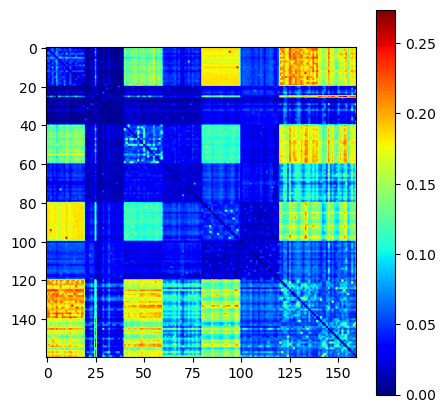

In [52]:
plt.figure(figsize=(5,5))
plt.imshow(mpgw, cmap='jet')
plt.colorbar()
plt.show()

# Unbalanced GW

In [245]:
st = time.time()        
ugw = np.zeros((N,N))

for i in tqdm(range(N)):
    shape_i = posns[i]
    M1 = Ms[i]
    M1 = torch.from_numpy(M1).to(device)
    height1 = heights[i]
    height1 = torch.from_numpy(height1).to(device)


    for j in range(i+1, N):
        shape_j = posns[j]
        M2 = Ms[j]
        M2 = torch.from_numpy(M2).to(device)
        height2 = heights[j]
        height2 = torch.from_numpy(height2).to(device)

        eps = 1e-1
        rho = rho2 = 1

        pi, gamma = exp_ugw_sinkhorn(height1, M1, height2, M2, init=None, 
                                     eps=eps,
                                     rho=rho, 
                                     rho2=rho2,
                                     nits_plan=1000, tol_plan=1e-5, nits_sinkhorn=1000, 
                                     tol_sinkhorn=1e-5, two_outputs=True)
        
        # print(gamma.max())

        cost = ugw_cost(pi, gamma, height1, M1, height2, M2, eps=eps, rho=rho, rho2=rho2)
        ugw[i, j] = cost


    

ugw[ugw < 0] = 0
ugw = np.sqrt(ugw)
ugw += ugw.T
for i in range(N):
    ugw[i,i]=ugw[i,i]/2
et = time.time()
print("ugw computation: " + str(np.round(et-st,2)) + "s")

  0%|          | 0/160 [00:00<?, ?it/s]

ugw computation: 2221.5s


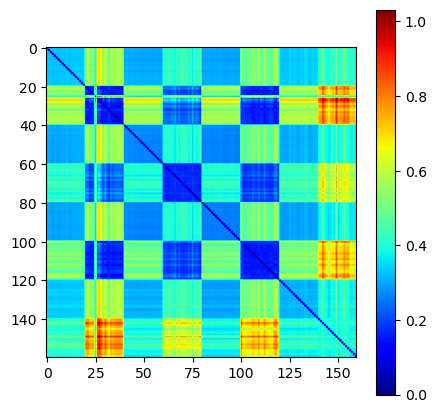

In [264]:
plt.figure(figsize=(5,5))
plt.imshow(ugw, cmap='jet')
plt.colorbar()
plt.show()

# Save/Load Dist Matrices

In [248]:
# Save all distance matrices
save = False
if save:
    np.savez("bone_star_dist_res.npz", gw=gw, pgw=pgw, mpgw=mpgw, ugw=ugw)

In [249]:
load = True
if load:
    dists = np.load("bone_star_dist_res.npz")
    gw, pgw, mpgw, ugw = dists.values()
    numItem = 20
    classes = np.arange(8)
    N = len(classes)*20

# Perform 10-fold cross validation

In [250]:
X = np.arange(N)                                           # dataset
y = np.concatenate([np.ones(numItem)*i for i in classes])  # labels

In [267]:
def svm_cross_val(dist, gamma=10, k=10):
    dist_sq=dist
    k_folds = sklearn.model_selection.StratifiedKFold(n_splits = 10)
    k_folds.get_n_splits(X,y)

    accs = []

    for train_index, test_index in k_folds.split(X, y):
        
        # get train and test data for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # set up SVM
        kernel_train = np.exp(-gamma * dist_sq[X_train].T[X_train].T)
        svc = svm.SVC(kernel="precomputed")
        
        # fit SVM
        clf = svc.fit(kernel_train, y_train)

        kernel_test = np.exp(-gamma * dist_sq[X_test].T[X_train].T)
        acc = clf.score(kernel_test, y_test)
        accs.append(acc)

    return accs, np.mean(accs)

In [268]:
accs_gw, mean_acc_gw = svm_cross_val(gw/np.max(gw))
print("Mean accuracy for GW: ", mean_acc_gw)

accs_pgw, mean_acc_pgw = svm_cross_val(pgw/np.max(pgw))
print("Mean accuracy for PGW: ", mean_acc_pgw)

accs_mpgw, mean_acc_mpgw = svm_cross_val(mpgw/np.max(mpgw))
print("Mean accuracy for MPGW: ", mean_acc_mpgw)

accs_ugw, mean_acc_ugw = svm_cross_val(ugw/np.max(ugw))
print("Mean accuracy for UGW: ", mean_acc_ugw)

Mean accuracy for GW:  0.98125
Mean accuracy for PGW:  0.9625
Mean accuracy for MPGW:  0.08125
Mean accuracy for UGW:  0.89375


# Plot

In [262]:
def plot_dists(dists, labels):
    fig = plt.figure(figsize=(len(dists) * 6, 6))
    min_val, max_val = 0, 1

    grid = ImageGrid(fig, 111,          
                     nrows_ncols=(1,len(dists)),
                     axes_pad=0.15,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="7%",
                     cbar_pad=0.15,
                     )
    
    animal_strings = ["bone","rectangle", "goblet", "trapezoid", "star","disk", "horseshoe", "annulus"]
    x = [10,30,50,70,90,110,130,150]
    plt.setp(grid, xticks=x, xticklabels=animal_strings, yticks=x, yticklabels=animal_strings)
    
    for data, ax, title in zip(dists, grid, labels):
        data = data/np.max(data)
        im = ax.imshow(data, vmin = min_val, vmax = max_val,cmap = "jet")

        ax.set_title(title, fontsize=24)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
    
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)

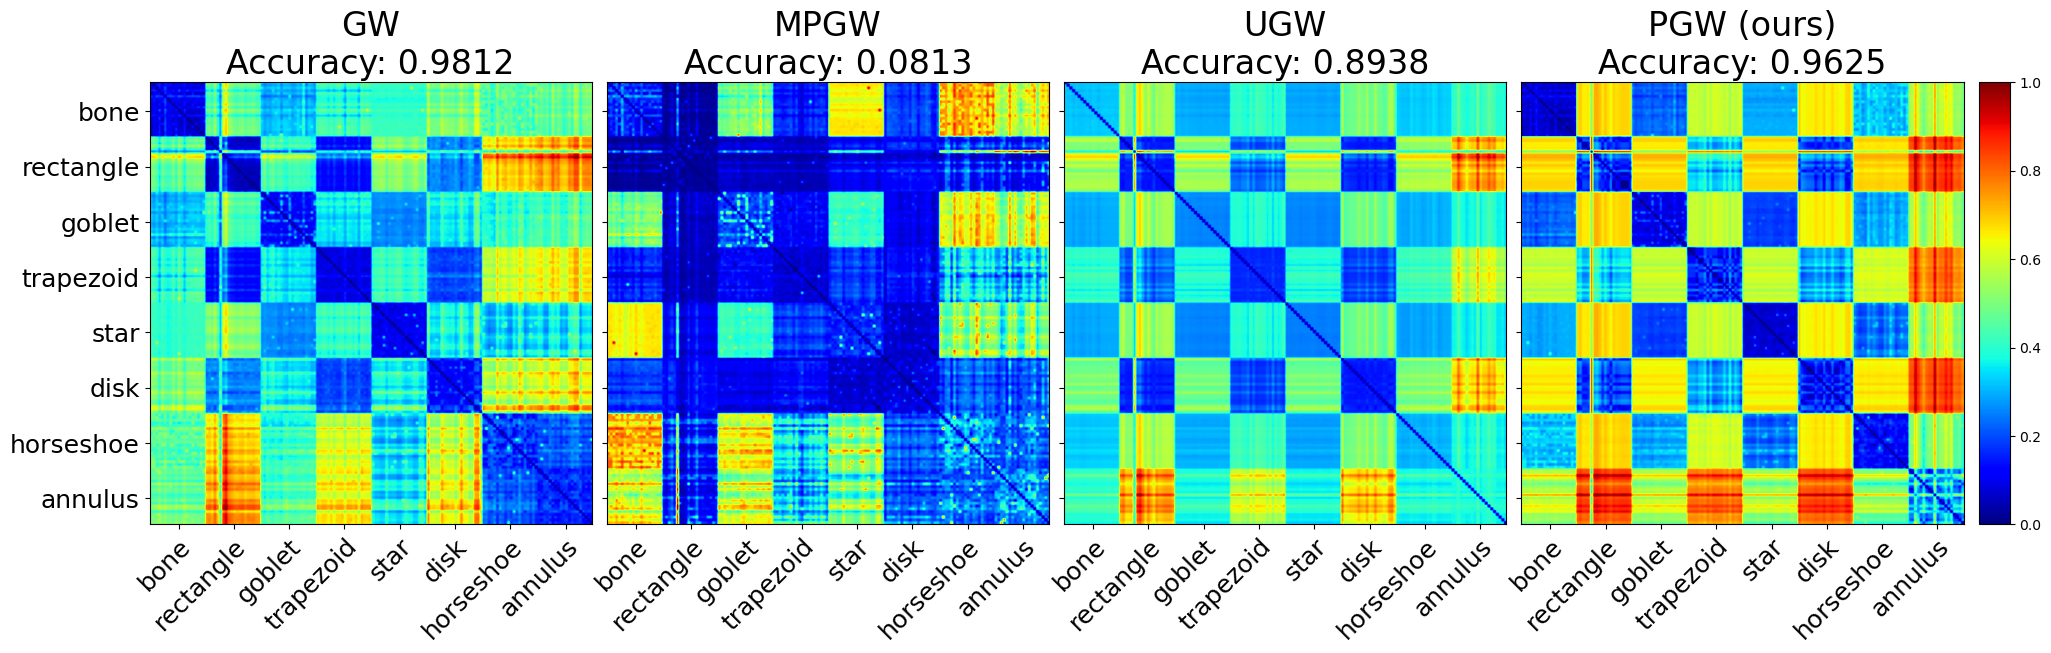

In [263]:
plot_dists([gw, mpgw, ugw, pgw], [f"GW\nAccuracy: {mean_acc_gw:.4f}", f"MPGW\nAccuracy: {mean_acc_mpgw:.4f}", f"UGW\nAccuracy: {mean_acc_ugw:.4f}", f"PGW (ours)\nAccuracy: {mean_acc_pgw:.4f}"])
plt.savefig("result/bone_star_dists.png", bbox_inches='tight', dpi=300)
plt.savefig("result/bone_star_dists.pdf", bbox_inches='tight', dpi=300)

# Confusion Matrix

In [19]:
def conf_mat(dists, X, y, n_its = 10000):
    N = len(y)
    classes = np.array(np.unique(y),dtype=int)
    x_pred = []
    x_true = []
    for j in range(n_its):
        l = []
        for i in classes:
            l.append([np.random.choice(X[y == i]),i])
        l = np.array(l)
        for i in range(N):
            tmp1 = np.argmin(dists[i][l[:,0]])
            x_true.append(y[i])
            x_pred.append(tmp1)
    
    conf = sklearn.metrics.confusion_matrix(x_true, x_pred)
    return conf

def plot_conf(confs, labels):
    fig = plt.figure(figsize=(len(confs) * 6, 6))
    min_val, max_val = 0, 1

    grid = ImageGrid(fig, 111,          
                     nrows_ncols=(1,len(confs)),
                     axes_pad=0.15,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="7%",
                     cbar_pad=0.15,
                     )
    
    animal_strings = ["bone","rectangle", "goblet", "trapezoid", "star","disk", "horseshoe", "annulus"]
    x = list(range(len(animal_strings)))
    plt.setp(grid, xticks=x, xticklabels=animal_strings, yticks=x, yticklabels=animal_strings)
    
    for data, ax, title in zip(confs, grid, labels):
        data = data/np.max(data)
        im = ax.imshow(data, vmin = min_val, vmax = max_val,cmap = "jet")

        ax.set_title(title, fontsize=24)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
    
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)

In [20]:
#compute confusion matrices
conf_gw = conf_mat(gw, X=X, y=y)
conf_pgw = conf_mat(pgw, X=X, y=y)
conf_mpgw = conf_mat(mpgw, X=X, y=y)
conf_ugw = conf_mat(ugw, X=X, y=y)

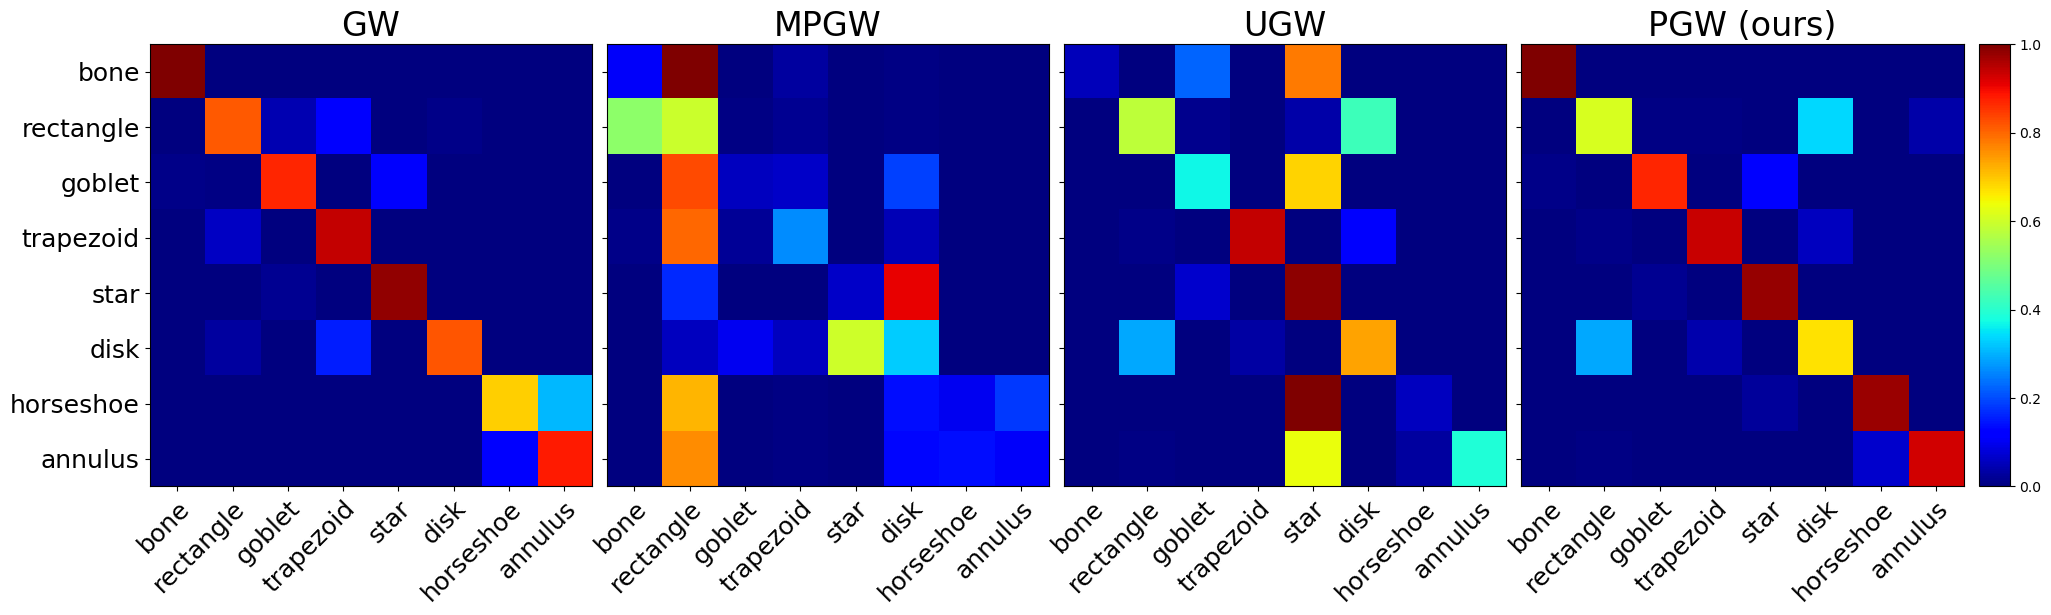

In [22]:
plot_conf([conf_gw, conf_mpgw, conf_ugw, conf_pgw], labels=["GW", "MPGW", "UGW", "PGW (ours)"])
plt.savefig("bone_star_conf.png", bbox_inches='tight', dpi=300)
plt.savefig("bone_star_conf.pdf", bbox_inches='tight', dpi=300)

In [222]:
A=np.array([[1,2],[3,4]])
print(A**2)

[[ 1  4]
 [ 9 16]]
